This is the ECOSTRESS notebook for use with the empirical OCS soil model
First import all the packages we'd like to use.
The packages must be downloaded first with conda (or some other package manager)

In [3]:
import rasterio
import numpy as np
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime as dt
from dateutil import parser
import pyproj 
from pyresample import geometry as geom
from pyresample import kd_tree as kdt
import sys
import gdal

Import the soil empirical model

In [139]:
sys.path.insert(0, '/Users/whelan/Dropbox/z_documents/python/soil_model/')
from COS_abiotic_biotic_soil_flux import ag_soil_OCS, wetland_OCS, tforest_soil_OCS, bforest_soil_OCS, grass_soil_OCS

Find the ECOSTRESS data that you downloaded earlier. 
ECOSTRESS data is in geotiff format -- a tiff (like an image) plus some geographical metadata.

In [18]:
# Find input directory (set this to where you put the data)
inDir = '/Users/whelan/Dropbox/z_documents/python/ECOSTRESS/ECOSTRESS_OK/'                                              
print("input directory:\n{}".format(inDir))

# Set output directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + os.sep  
print("output directory:\n{}".format(outDir))

# Create output directory if it's not already there
if not os.path.exists(outDir): 
    os.makedirs(outDir)
print("hello sailor")

input directory:
/Users/whelan/Dropbox/z_documents/python/ECOSTRESS/ECOSTRESS_OK/
output directory:
/Users/whelan/Dropbox/z_documents/python/ECOSTRESS/ECOSTRESS_OK/output/
hello sailor


ECOSTRESS generates data in individual files. 

ECO1BGEO.001 is the Geometric Calibration used the calibrate observation location.
    This has the height, zenith, and azimuth with land_fraction 

ECO2LSTE.001 is Land Surface Temperature and Emissivity at 70mx70m resolution.
    ECO2LSTE.001_SDS_LST is the Land Surface Temperature
    ECO2LSTE.001_SDS_LST_err is the associated error
    ECO2LSTE.001_SDS_EmisWB, Emis2, Emis4, and Emis5 is the emissivitity on each band
    ECO2LSTE.001_SDS_Emis(etc) err is the associated error
    ECO2LSTE.001_SDS_QC a quality control; for perfect data, the first two bits are 00 

This last one, ECO2LSTE.001_SDS_QC, has the QC including the cloud mask. 

ECO2CLD.001 is the cloud mask, throwing out data that is actually observation of clouds.

The standard format for files e.g. 
ECO2LSTE.001: the product type
00468: Orbit number; starting at start of mission, ascending equatorial crossing
007: Scene ID; starting at first scene of first orbit
20180805T220314: Date and time of data start: YYYYMMDDThhmmss
0502: Build ID of software that generated product, Major+Minor (2+2 digits)
02: Product version number (2 digits)

In [13]:
# List directory contents and create lists of ECOSTRESS tif files (GEO)
# geoList = np.array([file for file in os.listdir(inDir) if file.endswith('.tif') and 'GEO' in file])
#print("geolocation:\n{}".format("\n".join(geoList)))
ecoList = np.array([file for file in os.listdir(inDir) if file.endswith('.tif') and 'LST_d' in file])
#print("products:\n{}".format("\n".join(ecoList)))
#cldList = np.array([file.replace("_LST","_QC") for file in ecoList])
smList = np.array([file for file in os.listdir(inDir) if file.endswith('.tif') and 'soil_moisture_pm_d' in file])

Let's take a look at the first of the files and extract the timestamp.
The timestamp is in the format of four-digit year, three-digit day of year, two-digit hour, two-digit minute, and two-digit second.
We use the datetime package to reformat the information into a datatype that is recognized as time data

In [19]:
L2_LST_FILENAME = ecoList[41]
timestamp_UTC = L2_LST_FILENAME.split("_")[-2][3:]
print(timestamp_UTC)
#aquisition_datetime_UTC = dt.datetime.strptime(timestamp_UTC, "%Y%j%H%M%S")
#aquisition_datetime_UTC.strftime("%Y-%m-%d %H:%M:%S UTC")

2020032202858


In [15]:
#Open a file and look at its guts
dataset = rasterio.open(inDir+L2_LST_FILENAME, "r") #the "r" here means "read" instead of "w" write
print (dataset.count) #this gives you the # of bands for the geotiff, should be 1
print (dataset.width) #how many columns
print (dataset.height) #how many rows
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)} 
#This tells you the band (number 1) is type 16-bit integer
print(dataset.bounds) #the bounds of the geotiff on planet Earth
print(dataset.transform) #transforms data to a location on earth via bounds
print(dataset.crs) #This tells you what projection your bounds are in, in my case EPSG:4326
#Between bounds, transform and crs, the geotif is located on the earth's surface
#Because in gdal bands are 1-indexed, we use 1 for our 1 band
band1 = dataset.read(1)
#print(np.unique(band1)) #<-- this give

1
807
469
BoundingBox(left=-97.90966418525207, bottom=36.35597806763142, right=-97.40046021692329, top=36.651909494082716)
| 0.00, 0.00,-97.91|
| 0.00,-0.00, 36.65|
| 0.00, 0.00, 1.00|
EPSG:4326


In [20]:
L2_CLOUD_FILENAME=L2_LST_FILENAME.replace("_LST","_QC")
dataset = rasterio.open(inDir+L2_CLOUD_FILENAME, "r") #the "r" here means "read" instead of "w" write
print (dataset.count) #this gives you the # of bands for the geotiff, should be 1
print (dataset.width) #how many columns
lst_width = dataset.width
lst_height = dataset.height
print (dataset.height) #how many rows
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)} 
#This tells you the band (number 1) is type 16-bit integer
print(dataset.bounds) #the bounds of the geotiff on planet Earth
print(dataset.transform) #transforms data to a location on earth via bounds
print(dataset.crs) #This tells you what projection your bounds are in, in my case EPSG:4326
#Between bounds, transform and crs, the geotif is located on the earth's surface
#Because in gdal bands are 1-indexed, we use 1 for our 1 band
band1 = dataset.read(1)
#print(np.unique(band1)) #<-- this give

1
807
469
BoundingBox(left=-97.90998324333785, bottom=36.35582506027637, right=-97.40076827810718, top=36.65176287774005)
| 0.00, 0.00,-97.91|
| 0.00,-0.00, 36.65|
| 0.00, 0.00, 1.00|
EPSG:4326


Okay, let's look at one of these files.
We'll use rasterio to open the geotiff. 

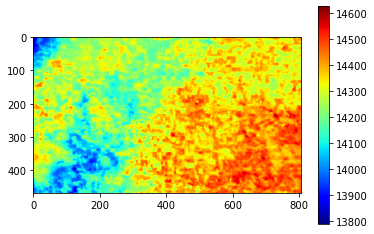

In [21]:
LST_FILL_VALUE = 0

with rasterio.open(inDir+L2_LST_FILENAME, "r") as LST_file:
    # read the first band of the raster image
    LST_DN = LST_file.read(1) #read the one band
    # we'll also load this GeoTIFF's metadata for when we need it to write a new file later
    profile = LST_file.profile

# we need to mask out the fill value in order for the image to preview correctly
LST_DN = np.where(LST_DN == LST_FILL_VALUE, np.nan, LST_DN)
#%matplotlib widget
plt.figure()
plt.imshow(LST_DN, cmap="jet")
plt.colorbar()
plt.show()

To save space, this product is stored as a 16-bit integer, which we call DNs or Digital Numbers. The DNs have to be scaled into real units. The scale factor for the ECOSTRESS LST product is 0.02. We'll multiply by that scale factor to get temperatures in Kelvin.

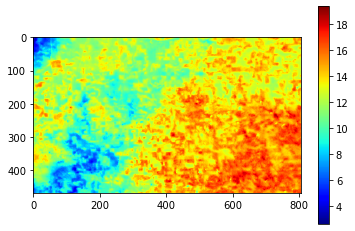

In [24]:
LST_SCALE_FACTOR = 0.02

LST_raw = LST_DN * LST_SCALE_FACTOR #Surface temperature "raw"
plt.figure()
plt.imshow(LST_raw-273.15, cmap="jet") #This is in C
plt.colorbar()
plt.show()

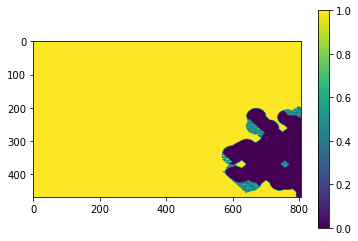

In [25]:
with rasterio.open(inDir+L2_CLOUD_FILENAME, "r") as cloud_file:
    QC = cloud_file.read(1)
    # to convert the QC to a cloud mask, we need to bit-shift one to the right and AND with one
    cloud_mask = (QC >> 1) & 1
    # in order to get a "true", the QC bit value needs to also be 1. 1 & 1 is true (1),
    # 0 & 1 is false.
    
plt.imshow(cloud_mask)
plt.colorbar()
plt.show()

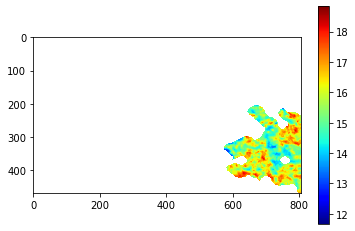

In [27]:
#Use the cloud mask
LST = np.where(cloud_mask, np.nan, LST_raw)
plt.imshow(LST-273.15, cmap="jet")
plt.colorbar()
plt.show()

In [149]:
print(np.shape(cloud_mask))
print(L2_CLOUD_FILENAME)
print(np.shape(LST_raw))
print(inDir+L2_LST_FILENAME)

(469, 807)
ECO2LSTE.001_SDS_QC_doy2020216194426_aid0001.tif
(469, 807)
/Users/whelan/Dropbox/z_documents/python/ECOSTRESS/ECOSTRESS_OK/ECO2LSTE.001_SDS_LST_doy2020216194426_aid0001.tif


1
6
4
BoundingBox(left=-97.95706473918283, bottom=36.351595835414855, right=-97.43276287617203, top=36.70113041075538)
| 0.09, 0.00,-97.96|
| 0.00,-0.09, 36.70|
| 0.00, 0.00, 1.00|
EPSG:4326
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 6, 'height': 4, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08738364383513186, 0.0, -97.95706473918283,
       0.0, -0.08738364383513186, 36.70113041075538)}
(None,)
[[0.30262834 0.3117822  0.31920442 0.32667276 0.32667276 0.3330042 ]
 [0.31182417 0.31315142 0.31888506 0.3317098  0.3317098  0.33251777]
 [0.320706   0.31622198 0.31753975 0.33279622 0.33279622 0.3340536 ]
 [0.3131469  0.31472048 0.31284106 0.32560533 0.32560533 0.33244696]]


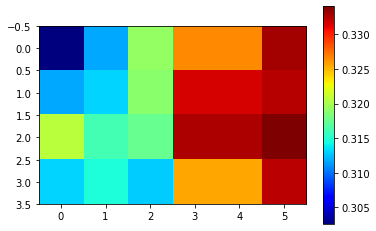

In [6]:
SMAP_FILENAME="SPL3SMP_E.003_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm_doy2020034_aid0001.tif"
dataset = rasterio.open(inDir+SMAP_FILENAME, "r") #the "r" here means "read" instead of "w" write
print (dataset.count) #this gives you the # of bands for the geotiff, should be 1
print (dataset.width) #how many columns
print (dataset.height) #how many rows
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)} 
#This tells you the band (number 1) is type 16-bit integer
print(dataset.bounds) #the bounds of the geotiff on planet Earth
print(dataset.transform) #transforms data to a location on earth via bounds
print(dataset.crs) #This tells you what projection your bounds are in, in my case EPSG:4326
#Between bounds, transform and crs, the geotif is located on the earth's surface
#Because in gdal bands are 1-indexed, we use 1 for our 1 band
SMAP = dataset.read(1)
#for name in dir(dataset):
#    print(name)
    
print(dataset.meta)
print(dataset.descriptions)
print(dataset.read(1))
plt.figure()
plt.imshow(dataset.read(1), cmap='jet')
plt.colorbar()
plt.show()
#print(np.unique(band1)) 

1
6
4
BoundingBox(left=-97.95706473918283, bottom=36.351595835414855, right=-97.43276287617203, top=36.70113041075538)
| 0.09, 0.00,-97.96|
| 0.00,-0.09, 36.70|
| 0.00, 0.00, 1.00|
EPSG:4326
{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 65534.0, 'width': 6, 'height': 4, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08738364383513186, 0.0, -97.95706473918283,
       0.0, -0.08738364383513186, 36.70113041075538)}
(None,)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [9 1 0 0 0 0]]


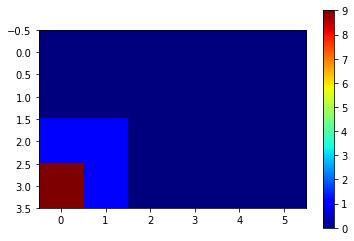

In [7]:
SMAP_QC_FILENAME="SPL3SMP_E.003_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm_doy2020034_aid0001.tif"
dataset = rasterio.open(inDir+SMAP_QC_FILENAME, "r") #the "r" here means "read" instead of "w" write
print (dataset.count) #this gives you the # of bands for the geotiff, should be 1
print (dataset.width) #how many columns
print (dataset.height) #how many rows
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)} 
#This tells you the band (number 1) is type 16-bit integer
print(dataset.bounds) #the bounds of the geotiff on planet Earth
print(dataset.transform) #transforms data to a location on earth via bounds
print(dataset.crs) #This tells you what projection your bounds are in, in my case EPSG:4326
#Between bounds, transform and crs, the geotif is located on the earth's surface
#Because in gdal bands are 1-indexed, we use 1 for our 1 band
SMAP_QC = dataset.read(1)
#for name in dir(dataset):
#    print(name)
SMAP_QC = SMAP_QC & 1
print(dataset.meta)
print(dataset.descriptions)
print(dataset.read(1))
plt.figure()
plt.imshow(dataset.read(1), cmap='jet')
plt.colorbar()
plt.show()
#print(np.unique(band1)) 

In [8]:
SMAP = np.where(SMAP_QC, np.nan, SMAP)

(469, 807)


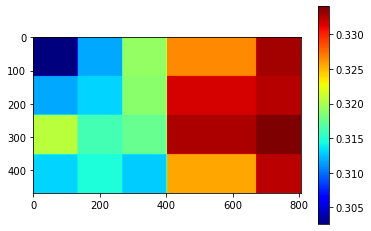

In [30]:
from rasterio.enums import Resampling
with rasterio.open(inDir+SMAP_FILENAME) as dataset:
    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(lst_height),
            int(lst_width)
        ),
        resampling=Resampling.nearest
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
print (data[0].shape)
plt.figure()
plt.imshow(data[0], cmap="jet")
plt.colorbar()
plt.show()